In [1]:
import os
os.chdir('..')
import h5py
import numpy as np
import cartopy.crs as ccrs
from notebooks import config
import numpy as np
from utils.imgShow import imgShow
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff
from utils.transform_xy import coor2coor
from utils.mad_std import mad_std


In [2]:
# !python utils/xover.py -h


In [3]:
path_img = config.root + '/data/rs_img/pine_island_S3A_20180207T115228_20180207T115528.tif'
path_atl06_A_merge = config.root + '/data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_A_merge.h5'
path_atl06_D_merge = config.root + '/data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_D_merge.h5'


In [4]:
s3_img, s3_img_info = readTiff(path_img)
print(s3_img_info)


{'geoextent': (-1741002.5304, -1437153.6139, -380178.3167, -165679.325), 'geotrans': (-1741002.5304, 295.8606781888998, 0.0, -165679.325, 0.0, -295.8606782068966), 'geosrs': '3031', 'row': 725, 'col': 1027, 'bands': 3}


In [5]:
with h5py.File(path_atl06_D_merge,'r') as f_a:
    lat_mergeD   = f_a['lat'][:]
    lon_mergeD   = f_a['lon'][:]
    h_elv = f_a['h_elv'][:]
    t_yrs_mergeD = f_a['t_year'][:]

lon_mergeD_proj, lat_mergeD_proj = coor2coor(srs_from=4326, srs_to=s3_img_info['geosrs'], x=lon_mergeD, y=lat_mergeD)



In [6]:
# !python utils/xover.py -h


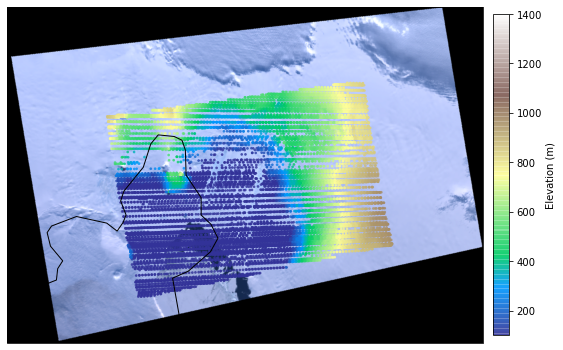

In [7]:
fig = plt.figure(figsize=(9,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
imgShow(s3_img, extent=s3_img_info['geoextent'], color_bands=(0, 1, 2), clip_percent=5)
plt.scatter(lon_mergeD_proj[::100], lat_mergeD_proj[::100], s=3, c=h_elv[::100], alpha=.7, cmap='terrain')
plt.clim([100,1400])
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation (m)')
ax.coastlines('50m')

In [8]:
# !python utils/xover.py -h


In [9]:
# !python utils/xover_.py data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_A_merge.h5 data/icesat2/land_ice_antarctic/preprocessed/pineisland_atl06_D_merge.h5 -o data/icesat2/land_ice_antarctic/preprocessed/pineisland_xovers.h5 -r 100 -p 3031 -d 10 -k 20 -m linear -v orbit lon lat t_year h_elv


In [10]:
with h5py.File('data/icesat2/land_ice_antarctic/preprocessed/pineisland_xovers.h5','r') as f_xo:
    lon_xovers = f_xo['lon'][:]
    lat_xovers = f_xo['lat'][:]
    dh_xovers = f_xo['h_elv_dif'][:]
    dt_xovers = f_xo['t_year_dif'][:]
    print(f_xo.keys())

dhdt_xovers = dh_xovers/dt_xovers
lon_xovers_proj, lat_xovers_proj = coor2coor('4326', '3031', lon_xovers, lat_xovers)


<KeysViewHDF5 ['h_elv_as', 'h_elv_des', 'h_elv_dif', 'lat', 'lon', 'orbit_as', 'orbit_des', 't_year_as', 't_year_des', 't_year_dif']>


Text(0.5, 0, 'dt_xovers')

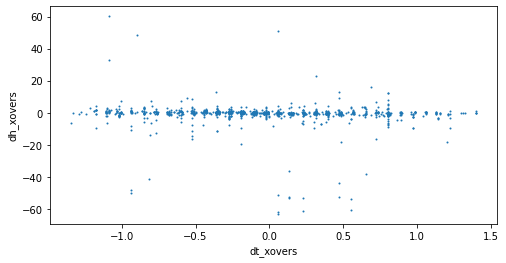

In [26]:
fig = plt.figure(figsize=(8,4))
plt.plot(dt_xovers, dh_xovers, '.', markersize=2)
plt.ylabel('dh_xovers')
plt.xlabel('dt_xovers')

## Distribution of the crossover points:   
1) all the crossover points; 
2) that time interval larger 3 months.

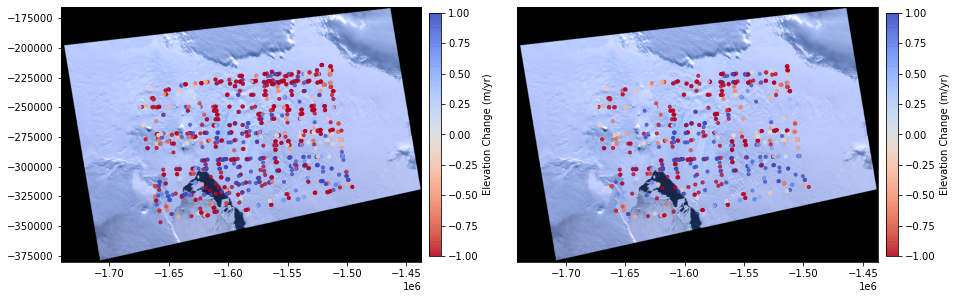

In [24]:
fig = plt.figure(figsize=(15,6))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
### all crossover points
plt.subplot(1,2,1)
imgShow(s3_img, extent=s3_img_info['geoextent'], color_bands=(0, 1, 2), clip_percent=5)
plt.scatter(lon_xovers_proj, lat_xovers_proj, s=10, c=dh_xovers/dt_xovers, \
                            alpha=.7, cmap='coolwarm_r')
plt.clim([-1.,1.])
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation Change (m/yr)')
ax.coastlines('50m')


### filtered crossover points
plt.subplot(1,2,2)
ids = np.abs(dt_xovers)> 3./12
imgShow(s3_img, extent=s3_img_info['geoextent'], color_bands=(0, 1, 2), clip_percent=5)
plt.scatter(lon_xovers_proj[ids], lat_xovers_proj[ids], s=10, c=dh_xovers[ids]/dt_xovers[ids], \
                            alpha=.7, cmap='coolwarm_r')
plt.clim([-1.,1.])
plt.yticks([])
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation Change (m/yr)')
ax.coastlines('50m')
